# Homework 4: Deep Convolutional Generative Adversarial Network (DCGAN) (100 points)

In this assignment, we're going to build and train a DCGAN model to generate synthetic pokemon images.

# Using GPUs in the Coursera environment

A GPU is required to complete this assignment. There is a potential issue.

 Coursera has sent along a potential solution while they’re further investigating the issue. We’ve tested this and it does seem to resolve the issue but we haven’t heard back yet from Coursera as to if there are things we should keep in mind or be wary of while using this solution so please know that you may want to save a local copy of your work just in case before using the following solution: 
 
 After having launched your assignment, you can append  <font color='red'>**&forceRefresh=beta-GPU**</font> to the end of the url in your browser (so a fake url of <font color='red'>**coursera.org/yourlab/filepath**</font> becomes <font color='red'>**coursera.org/yourlab/filepath&forceRefresh=beta-GPU)**</font>. 
 
 You will need to then hit enter to refresh the page with that parameter and it may send a prompt asking if you want to leave the site to which you would say yes (so that you let the page reload).
 
 Please note that it looks like if you remove the <font color='red'>**&forceRefresh=beta-GPU**</font> from the url (or relaunch it again after closing out of the page) you will likely need to add it back as you may lose the gpu access again.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision

from torch import nn
from d2l import torch as d2l
from tqdm import tqdm

# Loading Data (0 points)

This is an example of using a built-in torchvision dataloader for a vision dataset, no code needed here.

The original data can be retrieved from: [Kaggle - Pokemon Image Dataset](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset)

**Please note** that you will want to unzip the dataset (in `assets/data/pokemon.zip`) before you run this code for the first time. As the dataset is large, you may expect it to take about twenty minutes. 

In [2]:
# This cell has code to download the zipped dataset. No need to run this, the file 
# is already downloaded for you in the Coursera environment.

#d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
 #                          'c065c0e2593b8b161a2d7873e42418bf6a21106c')
#data_dir = d2l.download_extract('pokemon', folder='assets/data')

In [3]:
# Unzip the pokemon.zip file in 'assets/data/' to 'assets/data/pokemon' BEFORE running this cell
# Then this code will create a torchvision dataset for you to use.

pokemon = torchvision.datasets.ImageFolder('../data/pokemon/')

In [4]:
batch_size = 256

# the pipeline applied to images: resizing, scaling, normalizing
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer

# build data loader
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size, shuffle=True,
    num_workers=2) 

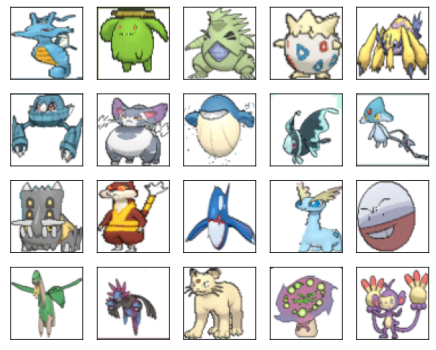

In [5]:
# Visualize a batch of data
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

# Question 1: Build the Generator

In this part, you will build the generator of a DCGAN. Each generator is composed of several generator blocks.

Each generator block should include a convolutional layer, batch normalization, and an activation function.

The generator then consists of 4 blocks with different input/output channels, a convolutional layer and an activation function.

Finally, we will put the blocks into an nn.Sequential module as we did in Homework 2.

You can follow the architecture proposed in the original paper: [Unsupervised Representation Learning
with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)

In [6]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, stride=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        ## TODO: implement DCGAN generator block
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        # raise NotImplementedError()

    def forward(self, X):
        ## TODO: feed input into the network you build
        # raise NotImplementedError()
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
net_G = nn.Sequential(
    ## TODO: implement the complete DCGAN generator with generator blocks
    ## The generator should end with a Tanh activation
    ## The output size should be (3, 64, 64)
    G_block(in_channels=100, out_channels=64*8, stride=1, padding=0), # Output: (64 * 8, 4, 4)
    G_block(in_channels=64*8, out_channels=64*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=64*4, out_channels=64*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=64*2, out_channels=64),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
) 

# raise NotImplementedError()

In [8]:
# assert statements to help check your solutions 

gb=G_block(100)
conv_num=0
batch_norm=0
for m in gb.modules():
    conv_num+=(type(m)==nn.ConvTranspose2d)
    batch_norm+=(type(m)==nn.BatchNorm2d)
assert conv_num==1, "Question 1: Number of 2D transposed convolution operators applied in G_block class does not match expected"
assert batch_norm==1, "Question 1: Number of batch normalizations applied does not match expected"


gblock_num=0
conv_num=0
for m in net_G:
    gblock_num+=(type(m)==G_block)
    conv_num+=(type(m)==nn.ConvTranspose2d)
assert gblock_num==4, "Question 1: Number of generator blocks does not match expected"
assert conv_num==1, "Question 1: Number of 2D transposed convolution operators applied in DCGAN generator does not match expected"


# Question 2: Build the Discriminator

In this question, you will build the discriminator. Each discriminator is composed of several discriminator blocks.

Each block should include a convolutional layer, batch normalization, and an activation function.

The discriminator then consists of 4 blocks with different input/output channels, and a convolutional layer.

Finally, we will put the blocks into an nn.Sequential module as we did in Homework 2.

You can follow the architecture proposed in the original paper: [Unsupervised Representation Learning
with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)

Hint: The original paper architecture uses a sigmoid. In the context of this asignment, this may lead to blurred images. If the output images are blurred, consider removing the sigmoid.

In [9]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, stride=2, padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        ## TODO: implement DCGAN discriminator block
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        ## TODO: feed input into the network you build
        # raise NotImplementedError()
        return self.activation(self.batch_norm(self.conv2d(X)))

In [10]:
net_D = nn.Sequential(
    ## TODO: implement the complete DCGAN discriminator with discriminator blocks
    ## The output size should be (1, 1, 1)
    D_block(64),  # Output: (64, 32, 32)
    D_block(in_channels=64, out_channels=64*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=64*2, out_channels=64*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=64*4, out_channels=64*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=64*8, out_channels=1, kernel_size=4, bias=False)
)  # Output: (1, 1, 1)
# raise NotImplementedError()

In [11]:
# assert statements to help check your solutions

db=D_block(100)
conv_num=0
batch_norm=0
for m in db.modules():
    conv_num+=(type(m)==nn.Conv2d)
    batch_norm+=(type(m)==nn.BatchNorm2d)
assert conv_num==1, "Question 2: Number of 2D transposed convolution operators applied in D_block class does not match expected"
assert batch_norm==1, "Question 2: Number of batch normalizations applied does not match expected"



dblock_num=0
conv_num=0
for m in net_D:
    dblock_num+=(type(m)==D_block)
    conv_num+=(type(m)==nn.Conv2d)
assert dblock_num==4, "Question 2: Number of discriminator blocks does not match expected"
assert conv_num==1, "Question 2: Number of 2D transposed convolution operators applied in DCGAN discriminator does not match expected"


# Train the Network

Since GANs can be hard to train, we provide the full training code, so no code is needed here. But feel free to tune the network yourself. Please don’t remove the print statement included in the ``train`` function, as the instructional team will be using it to check whether your loss decreases monotonically or not.

You should expect to find that the loss of the generator generally increases while the loss of the discriminator decreases over the epochs. The output images will potentially `real`.

In [12]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(10, 10),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in tqdm(range(1, num_epochs + 1)):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat([
            torch.cat([fake_x[i * 7 + j].cpu().detach()
                       for j in range(7)], dim=1)
            for i in range(len(fake_x) // 7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

100%|██████████| 20/20 [16:07<00:00, 48.38s/it]


loss_D 0.042, loss_G 7.065, 843.9 examples/sec on cuda:0


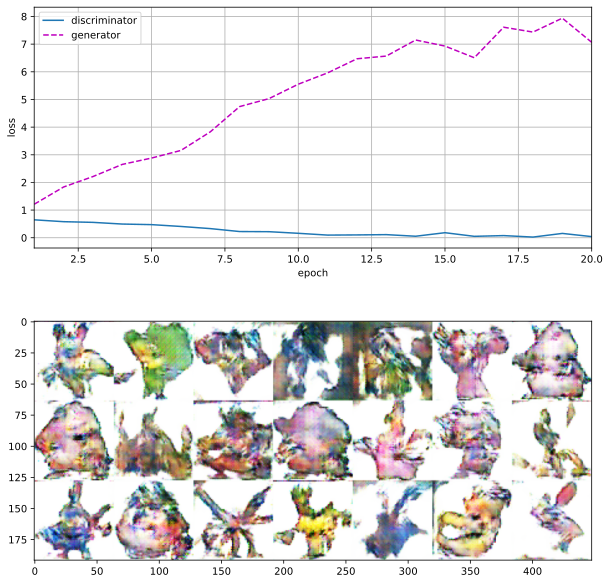

In [13]:
# Train the network on GPU
# See how the loss of D and G change over time, and how the final image generations look like.
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)